In [1]:
"""
Design a CNN
- Training can be done in GPU but the trained model most preferaby should still fit and make inference from CPU
- Even the training GPU memory usage cant be above 8GB
"""

'\nDesign a CNN\n- Training can be done in GPU but the trained model most preferaby should still fit and make inference from CPU\n- Even the training GPU memory usage cant be above 8GB\n'

In [2]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import StandardScaler

In [3]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


In [4]:
# Load data
train_data = pd.read_csv('./data_train.csv')
test_data = pd.read_csv('./data_val.csv')

print(f"Train: {len(train_data)}, Val: {len(test_data)}")
train_data.head()


Train: 441, Val: 111


,0,1,2,3,4,5,6,7,8,9,...,641,642,643,644,645,646,647,648,649,label
0,956,-118,-803,-517,-128,-204,-313,-92,-17,-264,...,-242.00,-214.000000,-133.000000,-100.0,-94.000000,-62.000000,-23.000000,-6.000000,12.000000,0
1,59,42,23,-2,-17,-2,14,23,29,14,...,-514.00,-491.000000,-482.000000,-474.0,-455.000000,-429.000000,-397.000000,-363.000000,-341.000000,2
2,-350,-350,-228,-245,-279,-275,-273,-247,-228,-241,...,-256.00,-192.000000,-239.000000,-220.0,-183.000000,-166.000000,-126.000000,-119.000000,-130.000000,0
3,-383,-467,-413,-203,-184,-398,-473,-231,-199,-253,...,-62.76,-67.245714,-61.108571,-45.8,-35.954286,-52.125714,-48.342857,-13.982857,-6.657143,0
4,-213,-100,-192,-234,-192,-213,-232,-224,-228,-158,...,-275.00,-267.000000,-269.000000,-205.0,-155.000000,-151.000000,-145.000000,-119.000000,-117.000000,0


In [5]:
# Normalize both train and val
scaler = StandardScaler()
train_data.iloc[:, :-1] = scaler.fit_transform(train_data.iloc[:, :-1])
test_data.iloc[:, :-1] = scaler.transform(test_data.iloc[:, :-1])
train_data.head()

,0,1,2,3,4,5,6,7,8,9,...,641,642,643,644,645,646,647,648,649,label
0,2.941908,-0.311118,-2.467952,-1.475485,-0.350660,-0.524555,-0.923681,-0.290551,-0.073381,-0.803469,...,-0.622114,-0.534090,-0.357374,-0.257571,-0.231938,-0.138880,-0.018564,0.038237,0.099868,0
1,0.205801,0.170054,0.107511,0.007496,-0.020497,0.084133,0.129077,0.069268,0.060631,0.035196,...,-1.468485,-1.335002,-1.373099,-1.302308,-1.223121,-1.131808,-1.067423,-0.931478,-0.930178,2
2,-1.041766,-1.008818,-0.675106,-0.692240,-0.799801,-0.738499,-0.794904,-0.775524,-0.688085,-0.734083,...,-0.665678,-0.470480,-0.665875,-0.592780,-0.476302,-0.420254,-0.307421,-0.268704,-0.314485,0
3,-1.142426,-1.360675,-1.251935,-0.571298,-0.517229,-1.109136,-1.438793,-0.725463,-0.603599,-0.770284,...,-0.064381,-0.109768,-0.148142,-0.106167,-0.072564,-0.112165,-0.089637,0.016553,0.045427,0
4,-0.623877,-0.256986,-0.562858,-0.660565,-0.541024,-0.551674,-0.662906,-0.703561,-0.688085,-0.483690,...,-0.724799,-0.687333,-0.753186,-0.550879,-0.399423,-0.379672,-0.360705,-0.268704,-0.276551,0


In [6]:
class ECGDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data.iloc[idx, :-1].values, dtype=torch.float32), torch.tensor(self.data.iloc[idx, -1], dtype=torch.int64)
    

def measure_accuracy(y_pred, y_true):
    return (y_pred.argmax(dim=1) == y_true).float().mean().item()

In [7]:
"""
Original Model from the ECG Adv paper: https://github.com/XintianHan/ADV_ECG/blob/master/model/CNN.py
Original model size = 5.4 million parameters # Original model GPU memory usage is 3.5GB

Split model into 2 parts:
CNN encoder with dim-6 after flatten and MLP head to get a single dim output

Refer to this to understand params like dilation: https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md
"""

# class ECGCNN(nn.Module):
#     def __init__(self, num_classes=3):
#         super(ECGCNN, self).__init__()
#         self.conv1 = nn.Conv1d(1, 128, kernel_size=16, stride=2, padding=0, bias=True)
#         self.conv2 = nn.Conv1d(128, 128, kernel_size=16, stride=2, padding=0, dilation=2, bias=True)
#         self.conv3 = nn.Conv1d(128, 128, kernel_size=16, stride=1, padding=0, dilation=2, bias=True)
#         self.conv4 = nn.Conv1d(128, 64, kernel_size=8, stride=1, padding=0, dilation=1, bias=True)
#         self.conv5 = nn.Conv1d(64, 64, kernel_size=8, stride=1, padding=0, dilation=1, bias=True)
#         self.conv6 = nn.Conv1d(64, 32, kernel_size=4, stride=1, padding=0, dilation=1, bias=True)
#         self.conv7 = nn.Conv1d(32, 32, kernel_size=4, stride=1, padding=0, dilation=1, bias=True)
#         self.conv8 = nn.Conv1d(32, 16, kernel_size=2, stride=1, padding=0, dilation=1, bias=True)

#         self.dropout = nn.Dropout(0.01) #  Set to 0.2 in submitted work

#         self.bn1 = nn.BatchNorm1d(128)
#         self.bn2 = nn.BatchNorm1d(128)
#         self.bn3 = nn.BatchNorm1d(128)
#         self.bn4 = nn.BatchNorm1d(64)
#         self.bn5 = nn.BatchNorm1d(64)
#         self.bn6 = nn.BatchNorm1d(32)
#         self.bn7 = nn.BatchNorm1d(32)
#         self.bn8 = nn.BatchNorm1d(16)

#         self.fc1 = nn.Linear(1488, 128)
#         self.fc2 = nn.Linear(128, 8)
#         self.fc3 = nn.Linear(8, num_classes)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = F.relu(x)
#         x = self.dropout(x)
#         x = self.conv2(x)
#         x = self.bn2(x)
#         x = F.relu(x)
#         x = self.dropout(x)
#         x = self.conv3(x)
#         x = self.bn3(x)
#         x = F.relu(x)
#         x = self.dropout(x)
#         x = self.conv4(x)
#         x = self.bn4(x)
#         x = F.relu(x)
#         x = self.dropout(x)
#         x = self.conv5(x)
#         x = self.bn5(x)
#         x = F.relu(x)
#         x = self.dropout(x)
#         x = self.conv6(x)
#         x = self.bn6(x)
#         x = F.relu(x)
#         x = self.dropout(x)
#         x = self.conv7(x)
#         x = self.bn7(x)
#         x = F.relu(x)
#         x = self.dropout(x)
#         x = self.conv8(x)
#         x = self.bn8(x)
#         x = F.relu(x)
#         x = self.dropout(x)

#         #print(x.shape)
#         # Flatten
#         x = x.view(x.size(0), -1)
#         #print(x.shape)

#         # MLP Head starts here
#         x = self.fc1(x)
#         x = F.relu(x)
#         x = self.fc2(x)
        
#         # Get Encoder output of 8 dimensions here
#         x = F.relu(x)
#         x = self.fc3(x)
#         x = F.softmax(x, dim=1)
#         return x


# https://www.kaggle.com/code/polomarco/ecg-classification-cnn-lstm-attention-mechanism

class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)
    
class ConvNormPool(nn.Module):
    """Conv Skip-connection module"""
    def __init__(
        self,
        input_size,
        hidden_size,
        kernel_size,
        norm_type='bachnorm'
    ):
        super().__init__()
        
        self.kernel_size = kernel_size
        self.conv_1 = nn.Conv1d(
            in_channels=input_size,
            out_channels=hidden_size,
            kernel_size=kernel_size
        )
        self.conv_2 = nn.Conv1d(
            in_channels=hidden_size,
            out_channels=hidden_size,
            kernel_size=kernel_size
        )
        self.conv_3 = nn.Conv1d(
            in_channels=hidden_size,
            out_channels=hidden_size,
            kernel_size=kernel_size
        )
        self.swish_1 = Swish()
        self.swish_2 = Swish()
        self.swish_3 = Swish()
        if norm_type == 'group':
            self.normalization_1 = nn.GroupNorm(
                num_groups=8,
                num_channels=hidden_size
            )
            self.normalization_2 = nn.GroupNorm(
                num_groups=8,
                num_channels=hidden_size
            )
            self.normalization_3 = nn.GroupNorm(
                num_groups=8,
                num_channels=hidden_size
            )
        else:
            self.normalization_1 = nn.BatchNorm1d(num_features=hidden_size)
            self.normalization_2 = nn.BatchNorm1d(num_features=hidden_size)
            self.normalization_3 = nn.BatchNorm1d(num_features=hidden_size)
            
        self.pool = nn.MaxPool1d(kernel_size=2)
        
    def forward(self, input):
        conv1 = self.conv_1(input)
        x = self.normalization_1(conv1)
        x = self.swish_1(x)
        x = F.pad(x, pad=(self.kernel_size - 1, 0))
        
        x = self.conv_2(x)
        x = self.normalization_2(x)
        x = self.swish_2(x)
        x = F.pad(x, pad=(self.kernel_size - 1, 0))
        
        conv3 = self.conv_3(x)
        x = self.normalization_3(conv1+conv3)
        x = self.swish_3(x)
        x = F.pad(x, pad=(self.kernel_size - 1, 0))   
        
        x = self.pool(x)
        return x
    
class ECGCNN(nn.Module):
    def __init__(
        self,
        input_size = 1,
        hid_size = 256,
        kernel_size = 5,
        num_classes = 3,
    ):
        
        super().__init__()
        
        self.conv1 = ConvNormPool(
            input_size=input_size,
            hidden_size=hid_size,
            kernel_size=kernel_size,
        )
        self.conv2 = ConvNormPool(
            input_size=hid_size,
            hidden_size=hid_size//2,
            kernel_size=kernel_size,
        )
        self.conv3 = ConvNormPool(
            input_size=hid_size//2,
            hidden_size=hid_size//4,
            kernel_size=kernel_size,
        )
        self.avgpool = nn.AdaptiveAvgPool1d((1))
        self.fc = nn.Linear(in_features=hid_size//4, out_features=8)
        
        # The removable head below
        self.fc2 = nn.Linear(in_features=8, out_features=num_classes)

        self.swish = Swish()
        
    def forward(self, input):
        x = self.conv1(input)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.avgpool(x)        
        # print(x.shape) # num_features * num_channels
        x = x.view(-1, x.size(1) * x.size(2))
        # print(x.shape)
        x = self.swish(self.fc(x))
        x = F.softmax(self.fc2(x), dim=1)

        return x
    
print(f"Total params: {sum(p.numel() for p in ECGCNN().parameters() if p.requires_grad)}")

# Print flatten layer dims after CNN encoder on a dummy input 
# model = ECGCNN()
# print(model(torch.randn(1, 1, 256)).shape)
# Reduced model 831,379 params (6.5x smaller than original model)
# This consumes 2.6 GB GPU memory

Total params: 1070819


In [8]:
# clear cache
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
NUM_EPOCHS = 400
LEARNING_RATE = 0.0001
BATCH_SIZE = 64
PRINT_EVERY_N_BATCHES = 5
PRINT_EVERY_EPOCHS = 1

train_dataset = ECGDataset(train_data)
test_dataset = ECGDataset(test_data)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

model = ECGCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_losses = []
test_losses = []
best_saved_model_data = {
    "epoch": None,
    "test_loss": None,
    "test_accuracy": None,
    "train_loss": None,
    "train_accuracy": None,
}
for epoch in range(NUM_EPOCHS):
    train_loss_batches = []
    train_accuracy_batches = []
    model.train()
    for i, (features, labels) in enumerate(train_loader):
        features = features.to(device)
        labels = labels.to(device)

        # Forward and Backward pass
        outputs = model(features.unsqueeze(1))
        loss = criterion(outputs, labels)
        train_loss_batches.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_accuracy = measure_accuracy(outputs, labels)
        train_accuracy_batches.append(train_accuracy)
        # if (i+1) % PRINT_EVERY_N_BATCHES == 0:
        #     print (f'Epoch [{epoch+1}/{NUM_EPOCHS}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
           
     # Average (across batches) train loss per epoch 
    train_loss = np.mean(train_loss_batches)
    model.eval()
    with torch.no_grad():
        test_loss_batches = []
        test_accuracy_batches = []
        for features, labels in test_loader:
            features = features.to(device)
            labels = labels.to(device)

            outputs = model(features.unsqueeze(1))
            loss = criterion(outputs, labels)
            test_loss_batches.append(loss.item())

            test_accuracy = measure_accuracy(outputs, labels)
            test_accuracy_batches.append(test_accuracy)
    
    test_loss = np.mean(test_loss_batches)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    if (epoch+1) % PRINT_EVERY_EPOCHS == 0:
        print (f"Epoch [{epoch+1}/{NUM_EPOCHS}]", end = "\t")
        print(f"Train loss: {train_loss}, Test loss: {test_loss}", end = "\t")
        print(f"Train accuracy: {round(100*np.mean(train_accuracy_batches),2)}%, Test accuracy: {round(100*np.mean(test_accuracy_batches),2)}%")

    # Save the best model so far 
    if epoch == 0 or test_loss < min(test_losses[:-1]):
        print("##### Saving Best Model #####")
        best_saved_model_data["epoch"] = epoch
        best_saved_model_data["test_loss"] = test_loss
        best_saved_model_data["test_accuracy"] = np.mean(test_accuracy_batches)
        best_saved_model_data["train_loss"] = train_loss
        best_saved_model_data["train_accuracy"] = np.mean(train_accuracy_batches)
        
        torch.save(model.state_dict(), 'best_model.pth')

print("Best Model Data: ", best_saved_model_data)


Epoch [1/400]	Train loss: 1.0837691341127669, Test loss: 1.0968627333641052	Train accuracy: 48.31%, Test accuracy: 35.27%
##### Saving Best Model #####
Epoch [2/400]	Train loss: 1.065075193132673, Test loss: 1.0932651162147522	Train accuracy: 59.41%, Test accuracy: 35.27%
##### Saving Best Model #####
Epoch [3/400]	Train loss: 1.0535211733409338, Test loss: 1.087020218372345	Train accuracy: 62.99%, Test accuracy: 35.27%
##### Saving Best Model #####
Epoch [4/400]	Train loss: 1.0419646160943168, Test loss: 1.075913906097412	Train accuracy: 65.27%, Test accuracy: 39.74%
##### Saving Best Model #####
Epoch [5/400]	Train loss: 1.0327739885875158, Test loss: 1.0546996593475342	Train accuracy: 66.44%, Test accuracy: 60.04%
##### Saving Best Model #####
Epoch [6/400]	Train loss: 1.026444435119629, Test loss: 1.0427244305610657	Train accuracy: 65.86%, Test accuracy: 62.67%
##### Saving Best Model #####
Epoch [7/400]	Train loss: 1.0180780036108834, Test loss: 1.0298109650611877	Train accuracy: 

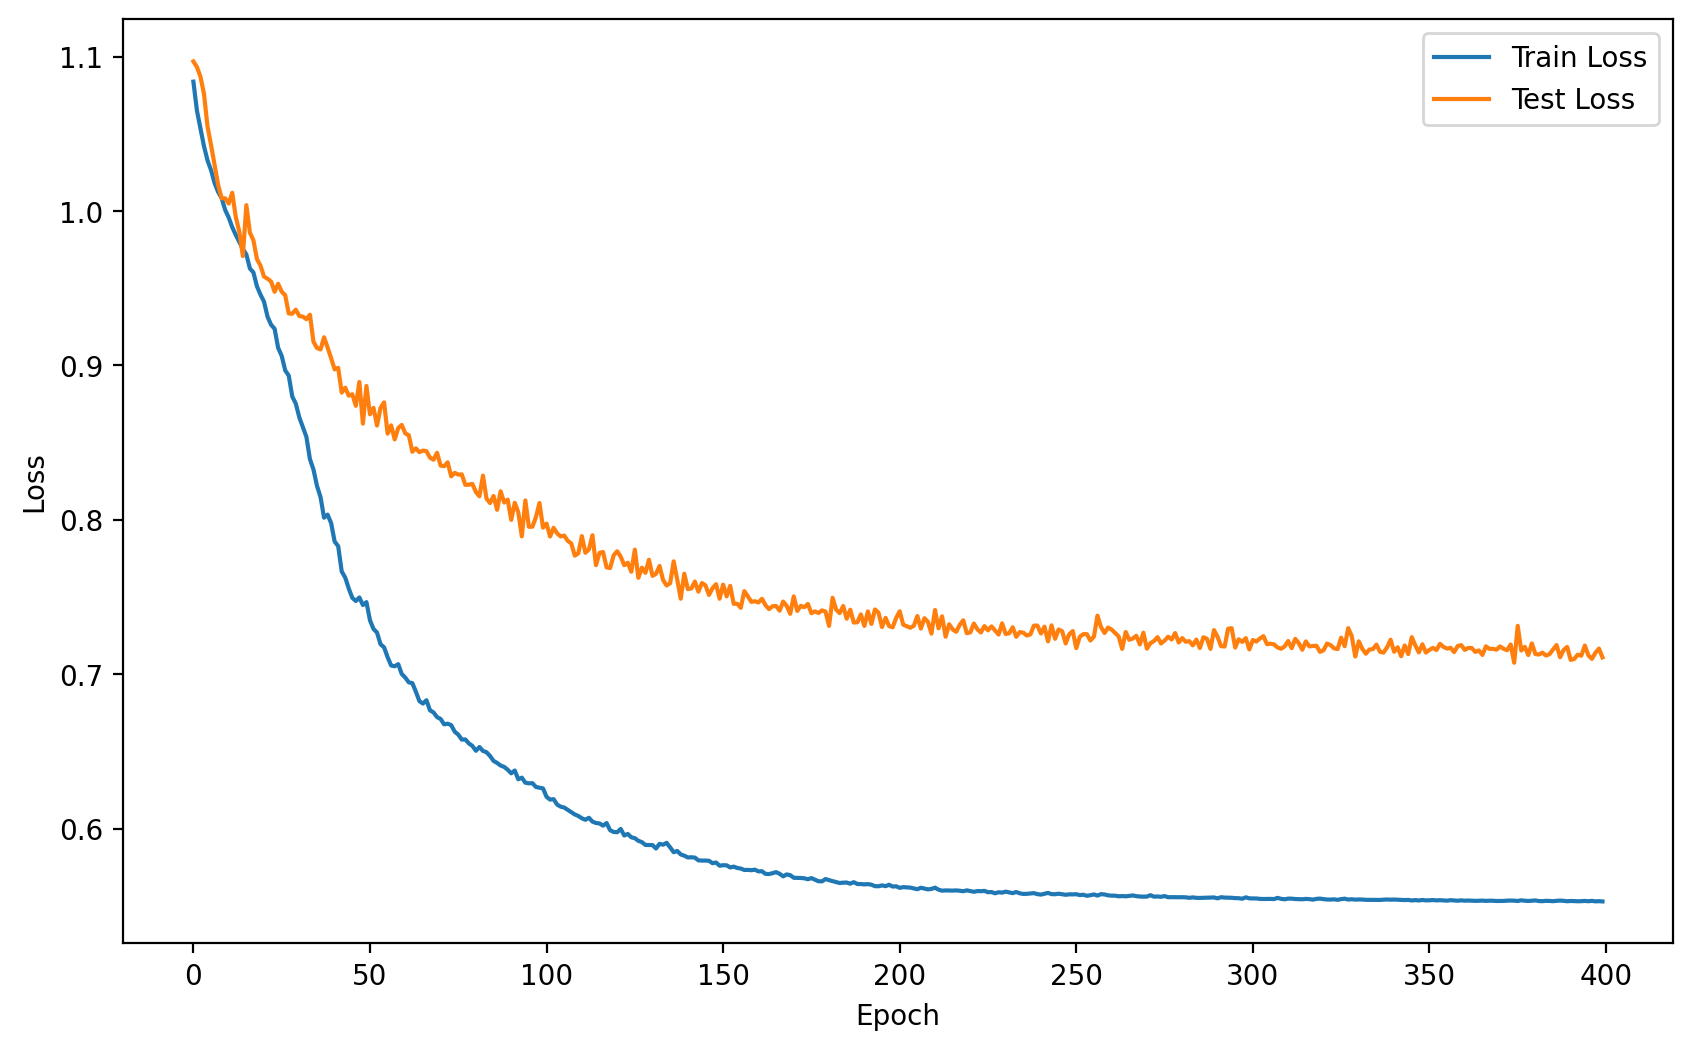

In [9]:
# Train accuracy: 96.8% and test accuracy 87.3% with 720,000 params
# around 90% seems like acceptable accuracy for this task: (https://www.mathworks.com/help/signal/ug/classify-ecg-signals-using-long-short-term-memory-networks.html)

# plot losses
fig, ax = plt.subplots(figsize=(10, 6), dpi = 200)
ax.plot(train_losses, label='Train Loss')
ax.plot(test_losses, label='Test Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
plt.show()